<a href="https://colab.research.google.com/github/AndreiAf02/Math574_Project/blob/main/Cholera_Fitter_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
%matplotlib inline
import arviz as az
import seaborn as sns

from pymc.ode import DifferentialEquation
from scipy.integrate import odeint

In [2]:
path_to_data = 'https://raw.githubusercontent.com/AndreiAf02/Math574_Project/main/'

In [3]:
data_cholera = pd.read_csv(path_to_data + "Zimbabwe_Cholera.csv", sep=",", header=0)
data_cholera = data_cholera[21:]
data_cholera = data_cholera[['Date', 'Zimbabwe', 'Zimb_cumul']]
data_cholera['Zimb_cumul'] = np.cumsum(data_cholera['Zimbabwe'])
data_cholera = data_cholera.reset_index(drop=True)
data_cholera

,Date,Zimbabwe,Zimb_cumul
0,03-Sep-23,3,3
1,08-Sep-23,30,33
2,17-Sep-23,38,71
3,22-Sep-23,58,129
4,30-Sep-23,204,333
5,07-Oct-23,343,676
6,13-Oct-23,339,1015
7,20-Oct-23,215,1230
8,28-Oct-23,372,1602
9,06-Nov-23,526,2128


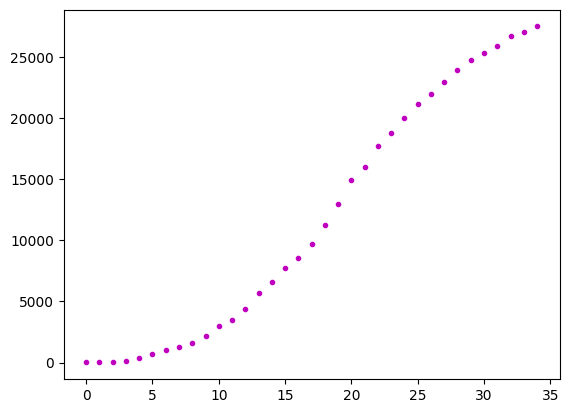

In [4]:
plt.plot(data_cholera['Zimb_cumul'], 'm.')

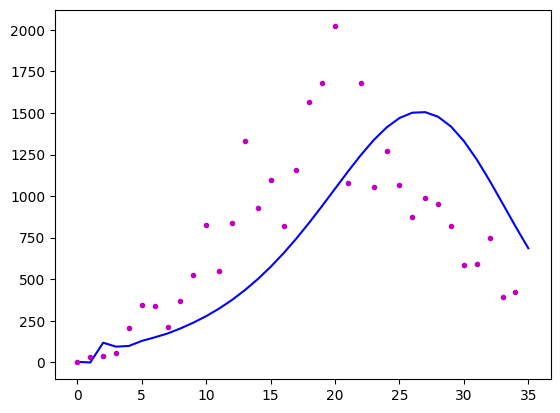

In [6]:
dt=1
max_time = 35
times = np.linspace(0,max_time,int(max_time/dt)+1)
p=0.90
pop = 350000


#a_val      Gamma   q_1    q_2         SumSq
#0.000045    1.0    0.09  0.009      1.807345e+06

c = 10000
c_s=0
c_h=0
c_f = 0
a = 0.000045
# a =3.72385744*10**(-9);
# xi = 0.964650025330277;

gamma = 1.0
d = 0.2


q_1 = 0.09
q_2 = 0.009

time = np.zeros(len(times))
S = np.zeros(len(times))
I = np.zeros(len(times))
A = np.zeros(len(times))
R = np.zeros(len(times))
B = np.zeros(len(times))
alph = np.zeros(len(times))

time[0] = 0
B[0]=10075
I[0] = 3.
S[0] = pop - I[0]
A[0] = 0

for t in range(len(times)-1):
    # print(t)
#     t = int(t)
    time[t+1] = time[t] + dt
    alph[t+1]=np.piecewise(B[t], [B[t] < c, B[t] >= c], [0, a*(B[t]-c)])
    S[t+1] = S[t]+(-(1-c_s)*(1-c_h)*alph[t]*S[t])*dt
    B[t+1] = B[t]+(q_1*I[t]+q_2*A[t])*dt
    I[t+1] = I[t] + dt*((1-p)*(1-c_s)*(1-c_h)*alph[t]*S[t]  - (gamma+d)*I[t])
    A[t+1] = A[t] + dt*(p*(1-c_s)*(1-c_h)*alph[t]*S[t]  - gamma*A[t])

Solution = pd.DataFrame()
Solution['time'] = times
Solution['S(t)'] = S
Solution['I(t)'] = I
Solution['A(t)'] = A
Solution['B(t)'] = B


plt.plot(Solution['time'], Solution['I(t)'], 'b-')
plt.plot(data_cholera['Zimbabwe'], 'm.')
# print(B[:100], A[:100])

In [7]:
def Cholera_model(y,t, a_val, gamma, d, q_1, q_2, p, thresh):
    S,I,A,B=y
    if B < thresh:
      a = 0
    else:
      a = a_val
    dS_dt=-(1-c_s)*(1-c_h)*a*(B-thresh)*S
    dI_dt=(1-p)*(1-c_s)*(1-c_h)*a*(B-thresh)*S - (gamma+d)*I
    dA_dt=p*(1-c_s)*(1-c_h)*a*(B-thresh)*S - gamma*A
    dB_dt = (1-c_f)*(q_1*I+q_2*A)
    return([dS_dt,dI_dt,dA_dt, dB_dt])



def Cholera_solver(mod, t, a_val, gamma, d, q_1, q_2, p, thresh):
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,A0,B0],t,args=(a_val,gamma, d, q_1, q_2, p, thresh))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['A(t)']=sol[:,2]
    Solution['B(t)']=sol[:,2]
    return Solution


def Cholera_fitter(mod, t, a_val, gamma, d, q_1, q_2, p, thresh, data, label):
    SumSq = pd.DataFrame(columns = ['SumSquared'])
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,A0,B0],t,args=(a_val,gamma, d, q_1, q_2, p, thresh))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['A(t)']=sol[:,2]
    Solution['B(t)']=sol[:,2]
    Sum=0
    for j in range(len(data)):
      for i in range(len(t)):
        if Solution['time'][i]==j:
          diff = (Solution['I(t)'][i]-data[label][j])**2
        else:
          diff = 0
        Sum = Sum+diff
    return Sum
    print(Sum)



In [8]:
pop = 350000
p=0.90

dt=1
max_time = 35
t = np.linspace(0,max_time,int(max_time/dt)+1)

a_val = 0.0000375
thresh = 10000
gamma = 0.96
d = 0.2
q_1 = 0.05
q_2 = 0.019

c_s=0
c_h=0
c_f = 0

I0 = 3
S0 = pop-I0
A0=0
B0=10075

output = Cholera_solver(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh)

fit = Cholera_fitter(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh, data_cholera, 'Zimbabwe')
fit

2996851.14692226

In [40]:
pop = 350000
p=0.90

dt=1
max_time = 35
t = np.linspace(0,max_time,int(max_time/dt)+1)

a_vals = np.linspace(0.00005, 0.00006, 11) #0.0000375
thresh = 10000
gamma_vals = np.linspace(1.0, 1.2, 21) #0.96
d = 0.2
q_1_vals = np.linspace(0.1, 0.2, 11) #0.05
q_2_vals = np.linspace(0.005, 0.015, 11) #0.009


I0 = 3
S0 = pop-I0
A0=0
B0=10075

c_s=0
c_h=0
c_f = 0

SumSq = []
Aval = []
Gamma = []
Q1 = []
Q2 = []

for a_val in a_vals:
  for gamma in gamma_vals:
    for q_1 in q_1_vals:
      for q_2 in q_2_vals:
        Result = Cholera_fitter(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh, data_cholera, 'Zimbabwe')
        Aval.append(a_val)
        Gamma.append(gamma)
        Q1.append(q_1)
        Q2.append(q_2)
        SumSq.append(Result)

ParamFit = pd.DataFrame([Aval, Gamma, Q1, Q2, SumSq]).T
ParamFit.columns=['a_val', 'Gamma', 'q_1', 'q_2', 'SumSq']
# print(ParamFit)

BestFit = pd.DataFrame()
BestFit = ParamFit.loc[ParamFit['SumSq']==ParamFit['SumSq'].min()]

print(BestFit)
BestFit = BestFit.to_numpy()



          a_val  Gamma  q_1    q_2         SumSq
13552  0.000055   1.07  0.1  0.005  1.489677e+06


In [41]:
BestFit2 = BestFit

a_val = BestFit[0,0]
gamma = BestFit[0,1]
q_1 = BestFit[0,2]
q_2 = BestFit[0,3]

print("a_val:", a_val, "gamma:", gamma, "q_1:", q_1, "q_2:", q_2)

output = Cholera_solver(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh)


a_val: 5.5e-05 gamma: 1.07 q_1: 0.1 q_2: 0.005


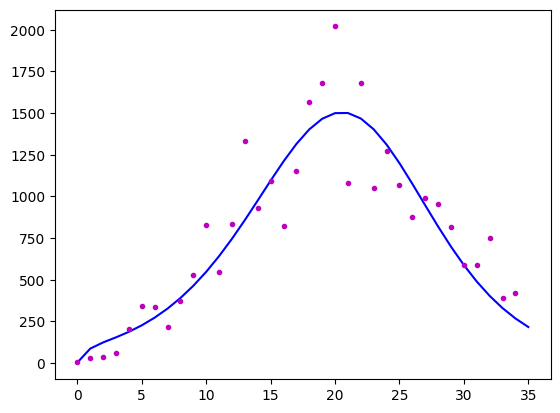

In [42]:
plt.plot(output['time'], output['I(t)'], 'b-')
plt.plot(data_cholera['Zimbabwe'], 'm.')

In [45]:
def trust(y,t,beta1, beta2, gamma1, gamma2, p):
    N,B,C=y
    dN_dt=-gamma1*N-beta1*B*N -beta2*C*N
    dB_dt= p * gamma1*N + beta1*B*N - gamma2*B
    dC_dt= (1-p) * gamma1*N + beta2*C*N + gamma2*B
    return([dN_dt,dB_dt,dC_dt])

             N(t)      B(t)      C(t)
0    1.000000e+00  0.000000  0.000000
1    9.007885e-01  0.079744  0.019468
2    8.042657e-01  0.157994  0.037740
3    7.119558e-01  0.233382  0.054662
4    6.251213e-01  0.304746  0.070133
..            ...       ...       ...
96   1.968386e-08  0.821757  0.178243
97   1.626058e-08  0.821675  0.178325
98   1.346206e-08  0.821593  0.178407
99   1.126139e-08  0.821510  0.178490
100  9.412654e-09  0.821428  0.178572

[101 rows x 3 columns]


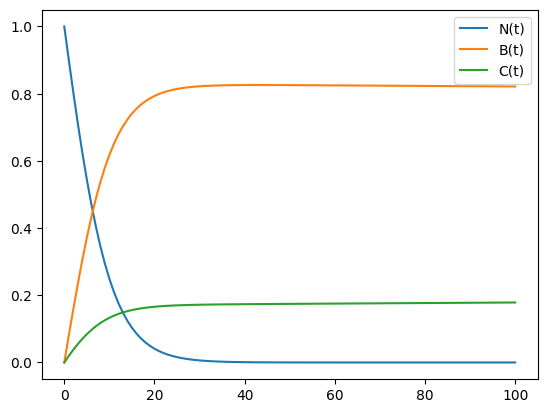

In [63]:
gamma1 = 1
beta1 = 1
beta2 = 0.5
p = 0.8
gamma2 = 0.001

N0=1
B0=0
C0=0

t = np.linspace(0, 10, 101)

solution = scipy.integrate.odeint(trust,[N0, B0, C0],t,args=(beta1, beta2, gamma1, gamma2, p))
Solution = pd.DataFrame()
Solution['N(t)']=solution[:,0]
Solution['B(t)']=solution[:,1]
Solution['C(t)']=solution[:,2]

print(Solution)

plt.figure()
plt.plot(Solution['N(t)'], label='N(t)')
plt.plot(Solution['B(t)'], label='B(t)')
plt.plot(Solution['C(t)'], label='C(t)')
plt.legend()

In [ ]:
def SIR_model(y,t,beta,gamma):
    S,I,A,B=y

    dS_dt=-beta*S*I
    dI_dt=beta*S*I-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


def SIR_solver(mod, t, N, beta, gamma):
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,R0],t,args=(beta,gamma))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['R(t)']=sol[:,2]
    return Solution



def SIR_plotter(sol, data):
    plt.figure(figsize=[6,4])
    plt.plot(sol['time'],sol['S(t)'],label="S(t)")
    plt.plot(sol['time'],sol['I(t)'],label="I(t)")
    plt.plot(sol['time'],sol['R(t)'],label="R(t)")
    plt.plot(data, 'm.')
    plt.grid()
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Number")
    plt.title("SIR model")
    plt.show()


def SIR_plotter_case(sol, data, label, label2, label3):
    plt.figure(figsize=[6,4], dpi=600)
    plt.plot(sol['time'],sol['I(t)'],label="I(t)")
    plt.plot(data['Hour'], data[label3], 'm.', label=label)
    plt.grid()
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.title(label2)
    plt.show()


def SIR_plotter_case_news(sol, data, label, label2):
    plt.figure(figsize=[6,4], dpi=600)
    plt.plot(sol['time'],sol['I(t)'],label="I(t)")
    plt.plot(data, 'm.', label=label)
    plt.grid()
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.title(label2)
    plt.show()


def SIR_fitter(mod, t, N, beta, gamma, data, label):
    SumSq = pd.DataFrame(columns = ['SumSquared'])
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,R0],t,args=(beta,gamma))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['R(t)']=sol[:,2]
    Sum=0
    for j in range(len(data)):
      for i in range(len(t)):
        if Solution['time'][i]==j:
          diff = (Solution['I(t)'][i]-data[label][j])**2
        else:
          diff = 0
        Sum = Sum+diff
    return Sum
    print(Sum)
    # SumSq=pd.DataFrame(Sum)
    # SumSq.loc[len(SumSq)] = Sum